In [1]:
import numpy as np
from keras.losses import SparseCategoricalCrossentropy
import os 
import tempfile
from keras.models import load_model, save_model
import tensorflow_model_optimization as tfmot
import tensorflow as tf
# Neural Network Tools is a self-build module to import necessary functions for training and evaluating the models
import Neural_Network_Tools.tools as nnt

In [2]:
(train_data, train_labels),(test_data, test_labels) = nnt.prepare_train_test_dataset()
num_training_samples = train_data.shape[0] * (1 - 0.1)
print(num_training_samples)

# get the end step for the polynomical decay pruning function
end_step = np.ceil(num_training_samples/128).astype(np.int32) * 8
print(end_step)
print(train_data.shape)

69371.1
4336
(77079, 4)


In [7]:
import numpy as np
import time

def evaluate_model(interpreter, test_data, test_labels):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # test_labels = np.argmax(test_labels, axis=1)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  test_start_time = time.time()
  for i, test_sample in enumerate(test_data):
    # if i % 1000 == 0:
    #   print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_sample = np.expand_dims(test_sample, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_sample)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  test_stop_time = time.time() - test_start_time
  print("Test time: ", test_stop_time)
  return accuracy

def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

def weight_pruning(baseline_model_path, train_data, train_labels, test_data, test_labels, batch_size, epochs, store_path):
    
  # create store path for models
  create_dir(store_path)

  # load baseline model from model path
  new_model = load_model(baseline_model_path)

  # evalute current baseline model accuracy
  _, baseline_model_accuracy = new_model.evaluate(
  test_data, test_labels, verbose=0)
  print('Original model test accuracy:', baseline_model_accuracy)

  # store it again: there are some problems with model overwriting, so store it again
  keras_file = os.path.join(store_path, "baseline_model.h5")
  tf.keras.models.save_model(new_model, keras_file, include_optimizer=False)
  print('Saved baseline model to:', keras_file)

  # Compute end step to finish pruning after 2 epochs.
  validation_split = 0.1 # 10% of training set will be used for validation set. 

  num_training_samples = train_data.shape[0] * (1 - validation_split)
  end_step = np.ceil(num_training_samples/batch_size).astype(np.int32) * epochs

  # Define model for pruning.
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                                final_sparsity=0.8,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(new_model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # model_for_pruning.summary()

  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  pruned_model_history = model_for_pruning.fit(train_data, train_labels, batch_size = 128, epochs=epochs, validation_split=validation_split,
                    callbacks=callbacks)
  
  nnt.plot_history(pruned_model_history, epochs, os.path.join(store_path,"history_pruned_fnn_model"))

  _, model_for_pruning_accuracy = model_for_pruning.evaluate(test_data, test_labels, verbose=0)

  print('Baseline model  test accuracy:', baseline_model_accuracy) 
  print('Pruned model test accuracy:', model_for_pruning_accuracy)

  model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

  pruned_keras_file = os.path.join(store_path,"pruned_model.h5")
  save_model(model_for_export, pruned_keras_file, include_optimizer=False)
  print('Saved pruned model to:', pruned_keras_file)

  converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
  pruned_tflite_model = converter.convert()

  interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)
  interpreter.allocate_tensors()

  tf_lite_test_accuracy = evaluate_model(interpreter, test_data, test_labels)
  print("TF Lite Test Accuracy: ", tf_lite_test_accuracy)

  pruned_tflite_file = os.path.join(store_path, "pruned_tflite_model.tflite")

  with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

  print('Saved pruned TFLite model to:', pruned_tflite_file)

  print("Size of gzipped baseline Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(keras_file)))
  print("Size of gzipped pruned Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(pruned_keras_file)))
  print("Size of gzipped pruned TFlite model: %.2f bytes" % (nnt.get_gzipped_model_size(pruned_tflite_file)))
  return interpreter


Original model test accuracy: 0.9941359758377075
Saved baseline model to: Pruning\baseline_model.h5
Epoch 1/8
  1/542 [..............................] - ETA: 27:40 - loss: 0.0101 - accuracy: 1.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.0841s). Check your callbacks.


542/542 [==============================] - 5s 4ms/step - loss: 0.0855 - accuracy: 0.9742 - val_loss: 0.0458 - val_accuracy: 0.9862
Epoch 2/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0921 - accuracy: 0.9699 - val_loss: 0.0398 - val_accuracy: 0.9866
Epoch 3/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0562 - accuracy: 0.9806 - val_loss: 0.1086 - val_accuracy: 0.9651
Epoch 4/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0510 - accuracy: 0.9826 - val_loss: 0.0229 - val_accuracy: 0.9913
Epoch 5/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0384 - accuracy: 0.9871 - val_loss: 0.0292 - val_accuracy: 0.9881
Epoch 6/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0646 - accuracy: 0.9853 - val_loss: 0.0205 - val_accuracy: 0.9926
Epoch 7/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0236 - accuracy: 0.9909 - val_loss: 0.0169 - val_accuracy: 0.9935
Epoch 8/8
542/542 [====

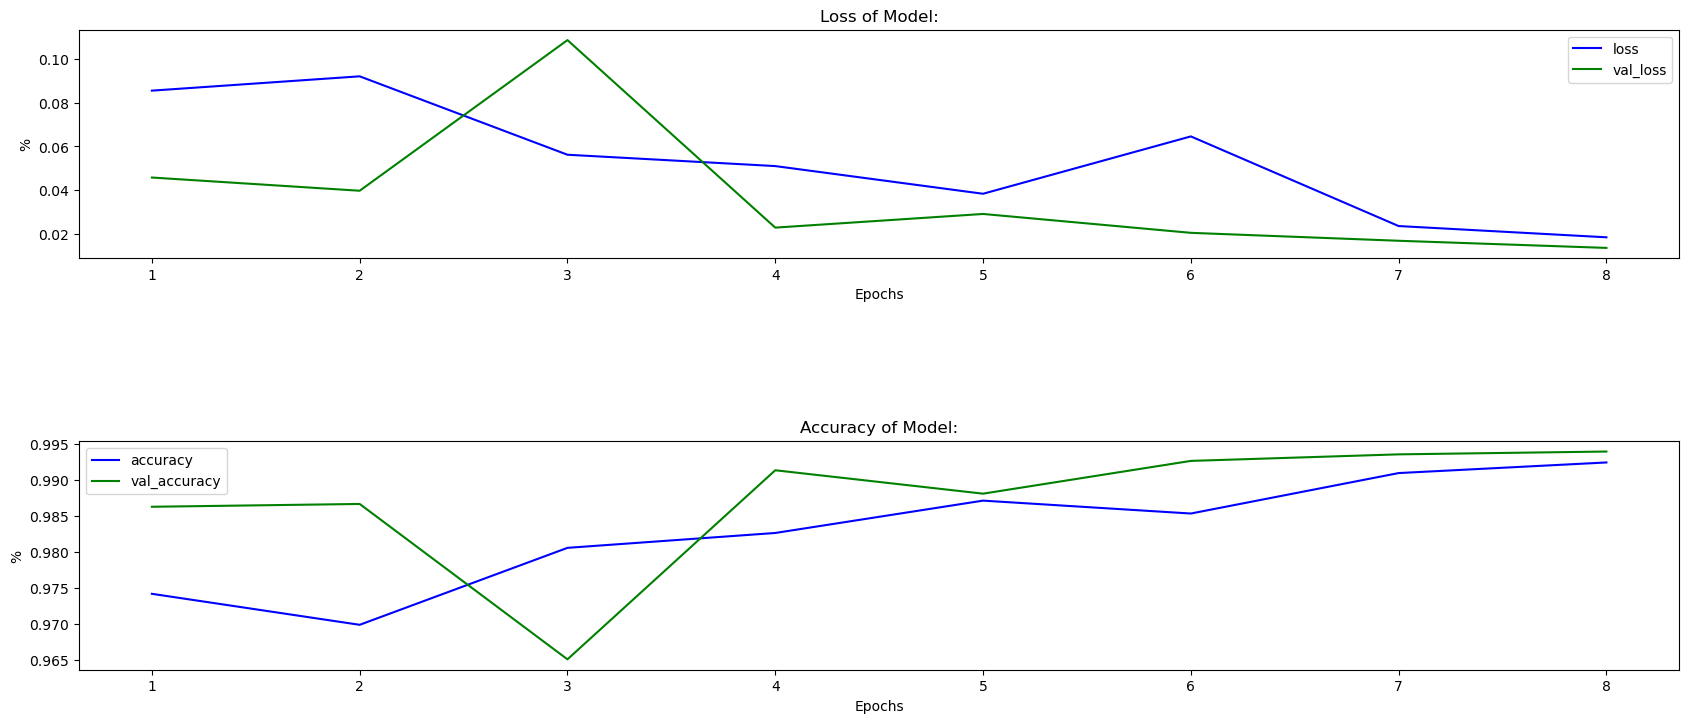

Baseline model  test accuracy: 0.9941359758377075
Pruned model test accuracy: 0.992890477180481


Saved pruned model to: Pruning\pruned_model.h5


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmposfij48o\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmposfij48o\assets




Test time:  0.377957820892334
TF Lite Test Accuracy:  0.9928905033731188
Saved pruned TFLite model to: Pruning\pruned_tflite_model.tflite
Size of gzipped baseline Keras model: 290002.00 bytes
Size of gzipped pruned Keras model: 95427.00 bytes
Size of gzipped pruned TFlite model: 93845.00 bytes


In [8]:
interpreter = weight_pruning("fnn_model.h5", train_data, train_labels, test_data, test_labels, batch_size=128, epochs=8, store_path="Pruning")

In [13]:
tf_lite_test_accuracy = evaluate_model(interpreter, test_data, test_labels)
print("TF Lite Test Accuracy: ", tf_lite_test_accuracy)



Test time:  0.37600111961364746
TF Lite Test Accuracy:  0.9928905033731188
